# Домашняя работа №1

In [ ]:
# Loading extension for reloading editable packages (pip install -e .)
%load_ext autoreload

In [ ]:
# Reloading editable packages.
%autoreload
# from lab1.main import get_results

Задание:

In [1]:
import pickle
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from numpy.typing import ArrayLike
from PIL import Image
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from tqdm import tqdm

%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Классификация изображений с использованием переноса обучения с ResNet
### Загрузка и распаковка набора данных

In [27]:
from glob import glob  # noqa
import os
from pathlib import Path

heigth_width = 32

CLASSES = ["man", "woman", "unknown"]  # Здесь требуется указать ваши классы

images = []
images_t = []
classes = []
classes_t = []

data_path = Path('../../data')

for CLASS in range(0, len(CLASSES)):
    class_path = f"{str(data_path)}/{CLASSES[CLASS]}"
    class_img_path = f"{class_path}/*.*"
    i = 0
    for photo in glob(class_img_path):
        i += 1
        img = Image.open(photo).convert("RGB")
        img = img.resize((heigth_width, heigth_width), Image.LANCZOS)
        if i > int(len(os.listdir(class_path)) * 0.8):
            images_t.append(np.asarray(img))
            classes_t.append(np.asarray(CLASS))
        else:
            images.append(np.asarray(img))
            classes.append(np.asarray(CLASS))


train_X = np.array(images)
train_y = np.array(classes)

test_X = np.array(images_t)
test_y = np.array(classes_t)
train_X, train_y, test_X, test_y

../../data/man/1 (42).png
../../data/man/1 (15).jpg
../../data/man/1 (15).png
../../data/man/1 (42).jpg
../../data/man/1 (3).jpeg
../../data/man/1 (20).jpeg
../../data/man/1 (78).jpg
../../data/man/1 (39).jpg
../../data/man/1 (39).png
../../data/man/1 (19).jpg
../../data/man/1 (58).jpg
../../data/man/1 (74).jpg
../../data/man/1 (23).png
../../data/man/1 (6).png
../../data/man/1 (6).jpg
../../data/man/1 (23).jpg
../../data/man/1 (35).jpg
../../data/man/1 (1).jpeg
../../data/man/1 (62).jpg
../../data/man/1 (35).png
../../data/man/1 (34).png
../../data/man/1 (63).jpg
../../data/man/1 (34).jpg
../../data/man/1 (5).jpeg
../../data/man/1 (7).jpg
../../data/man/1 (22).jpg
../../data/man/1 (7).png
../../data/man/1 (75).jpg
../../data/man/1 (59).jpg
../../data/man/1 (18).png
../../data/man/1 (18).jpg
../../data/man/1 (38).png
../../data/man/1 (38).jpg
../../data/man/1 (24).jpeg
../../data/man/1 (7).jpeg
../../data/man/1 (43).jpg
../../data/man/1 (14).png
../../data/man/1 (14).jpg
../../data/man

/Users/aspakalo/Projects/--educational/t5-2-/Neuroscience__/Homework1/.venv/lib/python3.12/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


../../data/woman/th-4240193894.jpg
../../data/woman/th-3622591264.jpg
../../data/woman/th-2821929162.jpg
../../data/woman/1 (27).jpeg
../../data/woman/th-905621938.jpg
../../data/woman/th-2578643986.jpg
../../data/woman/1 (66).png
../../data/woman/th-1017176330.jpg
../../data/woman/th-1128045902.jpg
../../data/woman/th-176801740.jpg
../../data/woman/th-500229576.jpg
../../data/woman/th-774145210.jpg
../../data/woman/th-1351560154.jpg
../../data/woman/th-1953288521.jpg
../../data/woman/1 (32).jpeg
../../data/woman/1 (77).jpeg
../../data/woman/th-660684282.jpg
../../data/woman/th-1676556154.jpg
../../data/woman/1 (48).jpeg
../../data/woman/th-3026621132.jpg
../../data/woman/1 (108).png
../../data/woman/th-1230338968.jpg
../../data/woman/1 (51).jpeg
../../data/woman/th-2698050450.jpg
../../data/woman/th-813648638.jpg
../../data/woman/1 (34).jpeg
../../data/woman/th-490247050.jpg
../../data/woman/th-2075477498.jpg
../../data/woman/th-3753092896.jpg
../../data/woman/th-2149586918.jpg
../../

### Чтение тренировочной и тестовой выборки

In [6]:
from pathlib import Path  # noqa


def stem_extensions(filename: Path):
    extensions = "".join(filename.suffixes)

    return str(filename).removesuffix(extensions)

In [8]:
def createImage(data: ArrayLike):
    return Image.fromarray(data).resize((256, 256))

In [9]:
# Source: https://stackoverflow.com/a/47334314
def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(10, 10)):
    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns + 1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i])
        plt.axis("off")
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i])

In [30]:
# По 3 экземпляра класса из выборки.
number_of_images_per_class_to_show = 3

for class_id in CLASSES:
    print(f"{class_id = }:")
    i = number_of_images_per_class_to_show
    image_index_for_class = -1
    class_images = []
    image_indices = []

    while i > 0:
        image_index_for_class = train_y.tolist().index(
            class_id, image_index_for_class + 1
        )
        image_indices.append(image_index_for_class)
        class_images.append(createImage(train_X[image_index_for_class]))
        i -= 1
    grid_display(class_images, image_indices, number_of_images_per_class_to_show)
    plt.show()

class_id = 'man':


ValueError: 'man' is not in list

### Создание Cifar Dataset с аугментацией

In [31]:
from torch import Tensor  # noqa
from torch.utils.data import Dataset  # noqa


class CifarDataset(Dataset):
    def __init__(self, X: Tensor, y: Tensor, transform=None, p=0.0):
        assert X.size(0) == y.size(0)
        super(Dataset, self).__init__()
        self.X = X
        self.y = y
        self.transform = transform
        self.prob = p

    def __len__(self):
        return self.y.size(0)

    def __getitem__(self, index):
        X = self.X[index]
        if self.transform and np.random.random() < self.prob:
            X = self.transform(X.permute(2, 0, 1) / 255).permute(1, 2, 0) * 255

        y = self.y[index]

        return X, y

Попробуем применить аугментацию к одной из картинок.

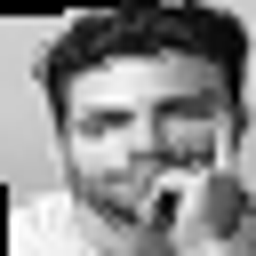

In [32]:
import torchvision.transforms as T  # noqa

transform = T.Compose(
    [
        T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.0),
        # shear - сдвиг.
        T.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=15),
    ]
)

Image.fromarray(
    (CifarDataset(Tensor(train_X), Tensor(train_y), transform=transform, p=1)[10])[0]
    .numpy()
    .astype(np.uint8)
).resize((256, 256))

### Создание Pytorch DataLoader'a

In [33]:
def create_dataloader(batch_size=128):
    dataloader: dict[str, DataLoader] = {}
    for (X, y), part in zip([(train_X, train_y), (test_X, test_y)], ["train", "test"]):
        tensor_x = torch.Tensor(X)
        tensor_y = (
            F.one_hot(torch.Tensor(y).to(torch.int64), num_classes=len(CLASSES)) / 1.0
        )
        dataset = CifarDataset(
            tensor_x, tensor_y, transform=transform if part == "train" else None, p=0.5
        )  # создание объекта датасета
        dataloader[part] = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=True,
            # prefetch_factor=8 if part == "train" else 2,
            # num_workers=2,
            # persistent_workers=True,
        )  # создание экземпляра класса DataLoader

    return dataloader

### Создание Pytorch модели свёрточной нейронной сети

In [34]:
HIDDEN_SIZE = 64


class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return x.permute(0, 3, 1, 2)  # nhwc -> nm


model = torch.hub.load(
    "chenyaofo/pytorch-cifar-models", "cifar100_resnet20", pretrained=True
)
model.to(device)
new_model = nn.Sequential(
    # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
    Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025]),
    model,
).to(device)
# Test run of model with noise input.
# print(new_model(torch.rand(1, 32, 32, 3).to(device)))
summary(new_model, input_size=(32, 32, 3))
new_model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 16, 32, 32]             432
       BatchNorm2d-3           [-1, 16, 32, 32]              32
              ReLU-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
             ReLU-10           [-1, 16, 32, 32]               0
       BasicBlock-11           [-1, 16, 32, 32]               0
           Conv2d-12           [-1, 16, 32, 32]           2,304
      BatchNorm2d-13           [-1, 16, 32, 32]              32
             ReLU-14           [-1, 16,

Using cache found in /Users/aspakalo/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Sequential(
  (0): Normalize()
  (1): CifarResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): 

### Создание логов для Tensorboard

In [35]:
import time  # noqa

from torch.utils.tensorboard import SummaryWriter  # noqa

%load_ext tensorboard

current_time = str(int(time.time()))

run_path = Path("runs/tensorboard")

train_run_path = run_path / "train" / current_time
test_run_path = run_path / "test" / current_time

train_summary_writer = SummaryWriter(log_dir=train_run_path)
test_summary_writer = SummaryWriter(log_dir=test_run_path)

## Перенос обучения
Обучим нашу модель сначала с заморозкой, затем полностью с разморозкой.

### Замена полносвязного слоя

In [36]:
in_features = new_model[1].fc.in_features
new_model[1].fc = nn.Linear(
    in_features=in_features, out_features=len(CLASSES), bias=True
)

new_model.to(device)
summary(new_model, input_size=(32, 32, 3))
print(new_model(torch.rand(1, 32, 32, 3).to(device)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 16, 32, 32]             432
       BatchNorm2d-3           [-1, 16, 32, 32]              32
              ReLU-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
             ReLU-10           [-1, 16, 32, 32]               0
       BasicBlock-11           [-1, 16, 32, 32]               0
           Conv2d-12           [-1, 16, 32, 32]           2,304
      BatchNorm2d-13           [-1, 16, 32, 32]              32
             ReLU-14           [-1, 16,

### Заморозка весов

In [37]:
print("Обучаемые параметры:")


def freeze(keep_last=2):
    total = len([*new_model.named_parameters()])
    params_to_update = []
    for i, (name, param) in enumerate(new_model.named_parameters()):
        if i < total - keep_last:
            param.requires_grad = False
        else:
            params_to_update.append(param)
            param.requires_grad = True
            print("\t", name)

    return new_model


new_model = freeze(keep_last=2)
summary(new_model, input_size=(32, 32, 3))

Обучаемые параметры:
	 1.fc.weight
	 1.fc.bias
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 16, 32, 32]             432
       BatchNorm2d-3           [-1, 16, 32, 32]              32
              ReLU-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
             ReLU-10           [-1, 16, 32, 32]               0
       BasicBlock-11           [-1, 16, 32, 32]               0
           Conv2d-12           [-1, 16, 32, 32]           2,304
      BatchNorm2d-13           [-1, 16, 32, 32]         

### Fine-tuning полносвязного слоя. Обучение модели по эпохам

In [38]:
REDRAW_EVERY = 20
# New: Changed epochs.
EPOCHS = 60


def train(
    model: nn.Module,
    criterion: nn.CrossEntropyLoss,
    optimizer: optim.Optimizer,
    dataloader: dict[str, DataLoader],
    scheduler: optim.lr_scheduler.LRScheduler,
    epochs=EPOCHS,
):
    steps_per_epoch = len(dataloader["train"])
    steps_per_epoch_val = len(dataloader["test"])

    pbar = tqdm(total=epochs * steps_per_epoch)
    losses = []
    losses_val = []
    passed = 0
    # Для создания чекпоинта
    best_acc = 0
    checkpoint_path = Path("cifar_resnet.pth")

    for epoch in range(epochs):  # проход по набору данных несколько раз
        tmp = []
        model.train()
        for i, batch in enumerate(dataloader["train"], 0):
            # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
            inputs, labels = batch

            # очищение прошлых градиентов с прошлой итерации
            optimizer.zero_grad()

            # прямой + обратный проходы + оптимизация
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

            # для подсчёта статистик
            accuracy = (
                labels.detach().argmax(dim=-1) == outputs.detach().argmax(dim=-1)
            ).to(torch.float32).mean().cpu() * 100
            tmp.append((loss.item(), accuracy.item()))
            pbar.update(1)

            with train_summary_writer as writer:
                writer.add_scalar("loss", tmp[-1][0], global_step=pbar.n)
                writer.add_scalar("accuracy", tmp[-1][1], global_step=pbar.n)

        losses.append(
            (
                np.mean(tmp, axis=0),
                np.percentile(tmp, 25, axis=0),
                np.percentile(tmp, 75, axis=0),
            )
        )
        scheduler.step()  # Обновляем learning_rate каждую эпоху.

        tmp = []
        model.eval()
        with torch.no_grad():  # отключение автоматического дифференцирования
            for i, data in enumerate(dataloader["test"], 0):
                inputs, labels = data
                # на GPU
                # inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                accuracy = (labels.argmax(dim=-1) == outputs.argmax(dim=-1)).to(
                    torch.float32
                ).mean().cpu() * 100
                tmp.append((loss.item(), accuracy.item()))
        losses_val.append(
            (
                np.mean(tmp, axis=0),
                np.percentile(tmp, 25, axis=0),
                np.percentile(tmp, 75, axis=0),
            )
        )
        with test_summary_writer as writer:
            writer.add_scalar("loss", losses_val[-1][0][0], global_step=pbar.n)
            writer.add_scalar("accuracy", losses_val[-1][0][1], global_step=pbar.n)

        acc = losses_val[-1][0][1]
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), checkpoint_path)

        # Обновление графиков.
        if (epoch + 1) % REDRAW_EVERY != 0:
            continue
        clear_output(wait=False)
        print(
            "Эпоха: %s\n"
            "Лучшая доля правильных ответов: %s\n"
            "Текущая доля правильных ответов: %s" % (epoch + 1, best_acc, acc)
        )
        passed += pbar.format_dict["elapsed"]
        pbar = tqdm(total=EPOCHS * steps_per_epoch, miniters=5)
        pbar.update((epoch + 1) * steps_per_epoch)
        x_vals = np.arange(epoch + 1)
        _, ax = plt.subplots(1, 2, figsize=(15, 5))
        stats = np.array(losses)
        stats_val = np.array(losses_val)
        ax[1].set_ylim(stats_val[:, 0, 1].min() - 5, 100)
        ax[1].grid(axis="y")
        for i, title in enumerate(["CCE", "Accuracy"]):
            ax[i].plot(x_vals, stats[:, 0, i], label="train")
            ax[i].fill_between(x_vals, stats[:, 1, i], stats[:, 2, i], alpha=0.4)
            ax[i].plot(x_vals, stats_val[:, 0, i], label="val")
            ax[i].fill_between(
                x_vals, stats_val[:, 1, i], stats_val[:, 2, i], alpha=0.4
            )
            ax[i].legend()
            ax[i].set_title(title)
        plt.show()

    model.load_state_dict(torch.load(checkpoint_path))
    print("Обучение закончено за %s секунд" % passed)

    return dataloader

In [39]:
# Запуск tensorboard в Jupyter Notebook.
%tensorboard --logdir runs/tensorboard

### Выбор функции потерь и оптимизатора градиентного спуска

Эпоха: 60
Лучшая доля правильных ответов: 74.64788818359375
Текущая доля правильных ответов: 73.23943328857422



100%|██████████| 180/180 [00:07<00:00, 24.01it/s]


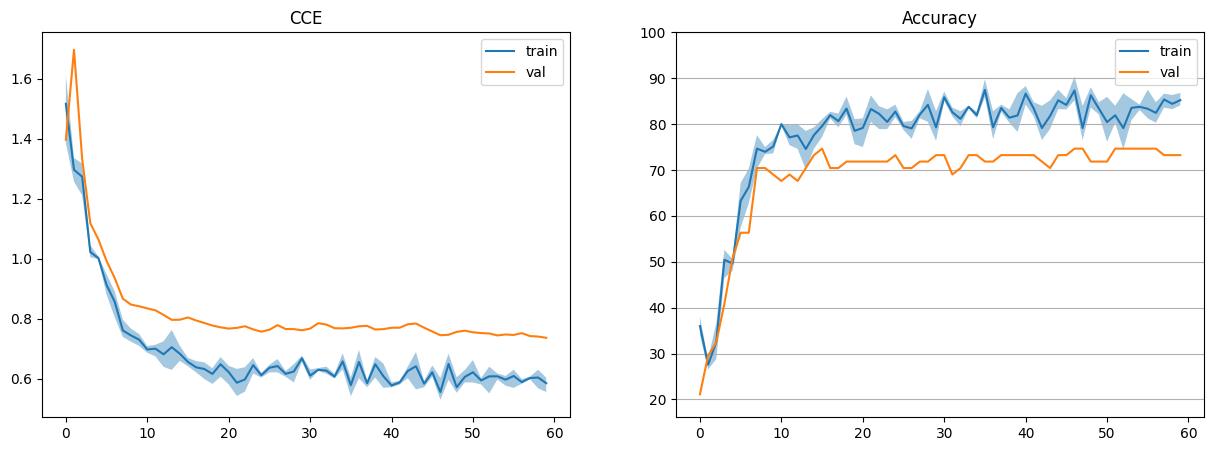

100%|██████████| 180/180 [00:00<00:00, 391.74it/s]

Обучение закончено за 22.79952573776245 секунд


In [40]:
def train_classifier(
    model: nn.Module,
    learning_rate=5e-3,
    batch_size=128,
    epochs=EPOCHS,
    momentum=0.9,
    # Регуляризация модели за счёт коэффициента, учитывающего сложность модели.
    # Норма параметров будет прибавлена к функции потерь. Чем больше
    # weight_decay, тем сильнее штраф за сложность.
    weight_decay=1e-5,
    # Добавляем сглаживание целевых меток, это увеличит значение функции потерь
    #   но полученная модель будет более устойчивой к выбросам в обучающей выборке.
    label_smoothing=0.1,
    # Постепенное уменьшение шага обучения каждые N эпох.
    scheduler_step_size=240,
):
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    optimizer = optim.SGD(
        model.parameters(),
        lr=learning_rate,
        momentum=momentum,
        weight_decay=weight_decay,
    )
    dataloader = create_dataloader(batch_size=batch_size)
    # Добавляем постепенное уменьшение шага обучения каждые step_size
    #   эпох.
    scheduler = optim.lr_scheduler.StepLR(
        optimizer=optimizer, step_size=scheduler_step_size, gamma=0.5
    )

    return train(
        model,
        criterion=criterion,
        optimizer=optimizer,
        dataloader=dataloader,
        epochs=epochs,
        scheduler=scheduler,
    )


dataloader = train_classifier(new_model)

### Проверка качества модели по классам на обучающей и тестовой выборках

In [41]:
def report_classification_results(dataloader: DataLoader):
    y_pred = []
    y_true = []
    with torch.no_grad():  # отключение автоматического дифференцирования
        for _, data in enumerate(dataloader, 0):
            inputs, labels = data
            # на GPU
            # inputs, labels = inputs.to(device), labels.to(device)

            outputs = new_model(inputs).detach().cpu().numpy()
            y_pred.append(outputs)
            y_true.append(labels.numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(
            classification_report(
                y_true.argmax(axis=-1),
                y_pred.argmax(axis=-1),
                digits=4,
                target_names=list(map(str, CLASSES)),
            )
        )

In [42]:
def compare_classification_reports(dataloader: dict[str, DataLoader]):
    for part in ["train", "test"]:
        print(part)
        report_classification_results(dataloader[part])
        part != "test" and print("-" * 53)

In [43]:
compare_classification_reports(dataloader)

train
              precision    recall  f1-score   support

         man     0.6953    0.8558    0.7672       104
       woman     0.8763    0.7870    0.8293       108
     unknown     0.9104    0.7625    0.8299        80

    accuracy                         0.8048       292
   macro avg     0.8273    0.8018    0.8088       292
weighted avg     0.8212    0.8048    0.8074       292

-----------------------------------------------------
test
              precision    recall  f1-score   support

         man     0.7586    0.8148    0.7857        27
       woman     0.7097    0.7857    0.7458        28
     unknown     0.8182    0.5625    0.6667        16

    accuracy                         0.7465        71
   macro avg     0.7622    0.7210    0.7327        71
weighted avg     0.7527    0.7465    0.7431        71



### Анализ результатов обучения модели
Как видно, результаты феноменальные. Мы достигли точности в 99,33%.

### Разморозим целиком модель

In [44]:
new_model = freeze(keep_last=66)  # More than total.
summary(new_model, input_size=(32, 32, 3))

	 1.conv1.weight
	 1.bn1.weight
	 1.bn1.bias
	 1.layer1.0.conv1.weight
	 1.layer1.0.bn1.weight
	 1.layer1.0.bn1.bias
	 1.layer1.0.conv2.weight
	 1.layer1.0.bn2.weight
	 1.layer1.0.bn2.bias
	 1.layer1.1.conv1.weight
	 1.layer1.1.bn1.weight
	 1.layer1.1.bn1.bias
	 1.layer1.1.conv2.weight
	 1.layer1.1.bn2.weight
	 1.layer1.1.bn2.bias
	 1.layer1.2.conv1.weight
	 1.layer1.2.bn1.weight
	 1.layer1.2.bn1.bias
	 1.layer1.2.conv2.weight
	 1.layer1.2.bn2.weight
	 1.layer1.2.bn2.bias
	 1.layer2.0.conv1.weight
	 1.layer2.0.bn1.weight
	 1.layer2.0.bn1.bias
	 1.layer2.0.conv2.weight
	 1.layer2.0.bn2.weight
	 1.layer2.0.bn2.bias
	 1.layer2.0.downsample.0.weight
	 1.layer2.0.downsample.1.weight
	 1.layer2.0.downsample.1.bias
	 1.layer2.1.conv1.weight
	 1.layer2.1.bn1.weight
	 1.layer2.1.bn1.bias
	 1.layer2.1.conv2.weight
	 1.layer2.1.bn2.weight
	 1.layer2.1.bn2.bias
	 1.layer2.2.conv1.weight
	 1.layer2.2.bn1.weight
	 1.layer2.2.bn1.bias
	 1.layer2.2.conv2.weight
	 1.layer2.2.bn2.weight
	 1.layer2.2.bn2

Эпоха: 60
Лучшая доля правильных ответов: 90.1408462524414
Текущая доля правильных ответов: 88.73239135742188



100%|██████████| 180/180 [00:24<00:00,  7.40it/s]


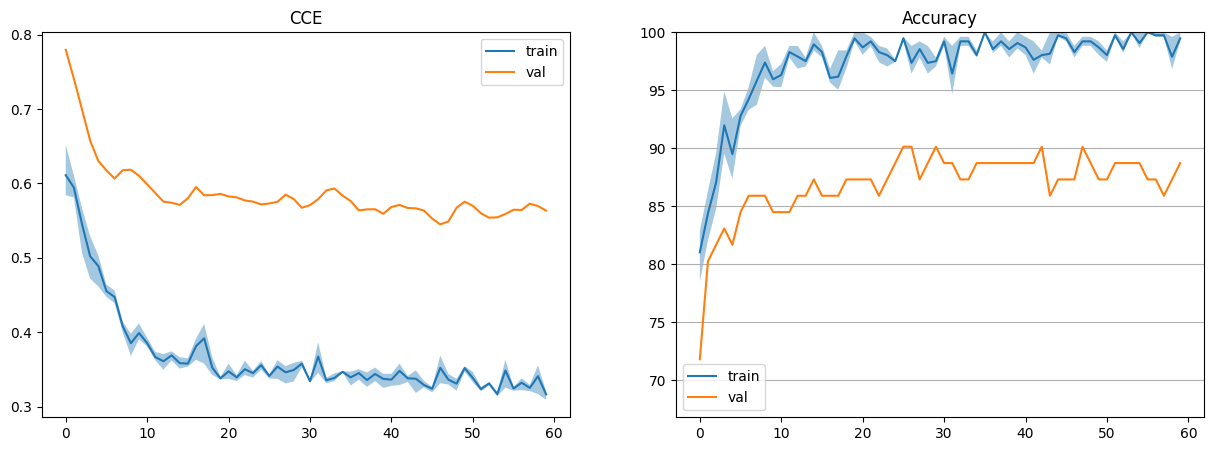

100%|██████████| 180/180 [00:00<00:00, 299.39it/s]

Обучение закончено за 58.15464997291565 секунд
train


              precision    recall  f1-score   support

         man     0.9720    1.0000    0.9858       104
       woman     0.9906    0.9722    0.9813       108
     unknown     1.0000    0.9875    0.9937        80

    accuracy                         0.9863       292
   macro avg     0.9875    0.9866    0.9869       292
weighted avg     0.9865    0.9863    0.9863       292

-----------------------------------------------------
test
              precision    recall  f1-score   support

         man     0.9200    0.8519    0.8846        27
       woman     0.8485    1.0000    0.9180        28
     unknown     1.0000    0.8125    0.8966        16

    accuracy                         0.9014        71
   macro avg     0.9228    0.8881    0.8997        71
weighted avg     0.9098    0.9014    0.9005        71



In [45]:
dataloader = train_classifier(new_model)
compare_classification_reports(dataloader)

In [46]:
new_model = freeze(keep_last=66)  # More than total.
summary(new_model, input_size=(32, 32, 3))

	 1.conv1.weight
	 1.bn1.weight
	 1.bn1.bias
	 1.layer1.0.conv1.weight
	 1.layer1.0.bn1.weight
	 1.layer1.0.bn1.bias
	 1.layer1.0.conv2.weight
	 1.layer1.0.bn2.weight
	 1.layer1.0.bn2.bias
	 1.layer1.1.conv1.weight
	 1.layer1.1.bn1.weight
	 1.layer1.1.bn1.bias
	 1.layer1.1.conv2.weight
	 1.layer1.1.bn2.weight
	 1.layer1.1.bn2.bias
	 1.layer1.2.conv1.weight
	 1.layer1.2.bn1.weight
	 1.layer1.2.bn1.bias
	 1.layer1.2.conv2.weight
	 1.layer1.2.bn2.weight
	 1.layer1.2.bn2.bias
	 1.layer2.0.conv1.weight
	 1.layer2.0.bn1.weight
	 1.layer2.0.bn1.bias
	 1.layer2.0.conv2.weight
	 1.layer2.0.bn2.weight
	 1.layer2.0.bn2.bias
	 1.layer2.0.downsample.0.weight
	 1.layer2.0.downsample.1.weight
	 1.layer2.0.downsample.1.bias
	 1.layer2.1.conv1.weight
	 1.layer2.1.bn1.weight
	 1.layer2.1.bn1.bias
	 1.layer2.1.conv2.weight
	 1.layer2.1.bn2.weight
	 1.layer2.1.bn2.bias
	 1.layer2.2.conv1.weight
	 1.layer2.2.bn1.weight
	 1.layer2.2.bn1.bias
	 1.layer2.2.conv2.weight
	 1.layer2.2.bn2.weight
	 1.layer2.2.bn2

Эпоха: 240
Лучшая доля правильных ответов: 91.5492935180664
Текущая доля правильных ответов: 87.32394409179688


720it [00:29, 24.06it/s]00:00<?, ?it/s]


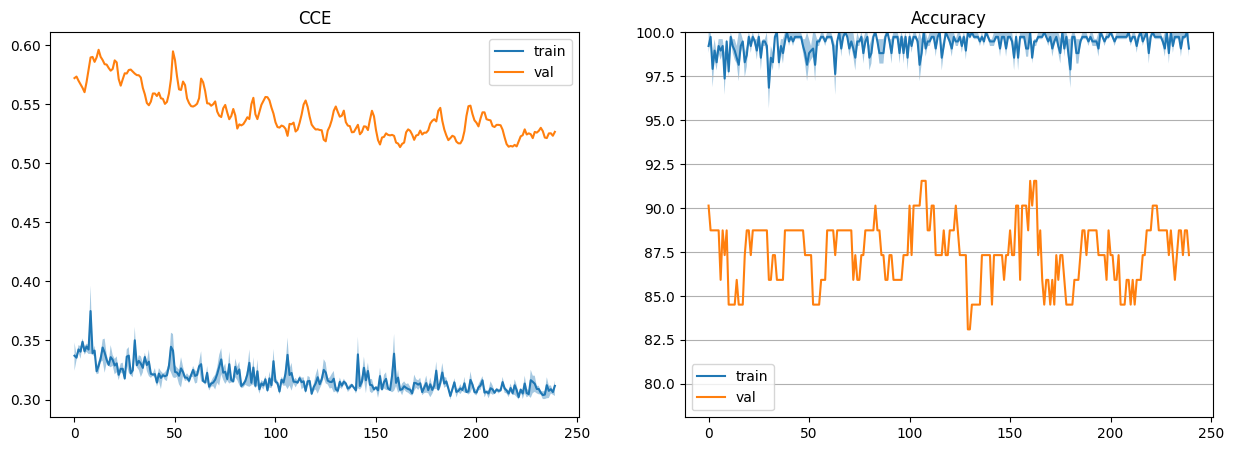

720it [00:01, 715.05it/s]              

Обучение закончено за 291.96040320396423 секунд
train


              precision    recall  f1-score   support

         man     0.9905    1.0000    0.9952       104
       woman     1.0000    0.9907    0.9953       108
     unknown     1.0000    1.0000    1.0000        80

    accuracy                         0.9966       292
   macro avg     0.9968    0.9969    0.9969       292
weighted avg     0.9966    0.9966    0.9966       292

-----------------------------------------------------
test
              precision    recall  f1-score   support

         man     0.8929    0.9259    0.9091        27
       woman     0.9032    1.0000    0.9492        28
     unknown     1.0000    0.7500    0.8571        16

    accuracy                         0.9155        71
   macro avg     0.9320    0.8920    0.9051        71
weighted avg     0.9211    0.9155    0.9132        71



In [47]:
dataloader = train_classifier(new_model, epochs=240)
compare_classification_reports(dataloader)

## Экспорт модели

In [ ]:
model_path = Path("models")
model_filename = "resnet_avatars_gender.pt"

model_path.mkdir(exist_ok=True)

model_file_path = model_path / model_filename

torch.save(model, model_file_path)
# загрузка
new_model_2 = torch.load(model_file_path)
new_model_2.eval()

In [ ]:
# входной тензор для модели
onnx_model_filename = "resnet_avatars_gender.onnx"
x = torch.randn(1, 32, 32, 3, requires_grad=True).to(device)
torch_out = new_model(x)

# экспорт модели
torch.onnx.export(
    new_model,  # модель
    x,  # входной тензор (или кортеж нескольких тензоров)
    model_path
    / onnx_model_filename,  # куда сохранить (либо путь к файлу либо fileObject)
    export_params=True,  # сохраняет веса обученных параметров внутри файла модели
    opset_version=9,  # версия ONNX
    do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
    input_names=["input"],  # имя входного слоя
    output_names=["output"],  # имя выходного слоя
    dynamic_axes={
        "input": {
            0: "batch_size"
        },  # динамичные оси, в данном случае только размер пакета
        "output": {0: "batch_size"},
    },
)